In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [83]:
og = pd.read_csv('/Users/gracesaunders/Downloads/World Development Indicators Jan 28 2025 (1)/WDICSV.csv')
og.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.488497,18.001597,18.558234,19.043572,19.586457,20.192064,20.828814,21.372164,22.100884,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.811504,7.096003,7.406706,7.666648,8.020952,8.403358,8.718306,9.097176,9.473374,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.152090,38.488233,38.779953,39.068462,39.445526,39.818645,40.276374,40.687817,41.211606,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.871956,33.922276,38.859598,40.223744,43.035073,44.390861,46.282371,48.127211,48.742043,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.672943,16.527554,24.627753,25.432092,27.061929,29.154282,31.022083,32.809138,33.760782,NaN


In [84]:
# remove other ODA data
non_oda_data = og[~og['Indicator Name'].str.contains(" aid ", regex=False, na=False, case=False)]
target_oda_data = og[og['Indicator Code'] == "DT.ODA.ODAT.KD"]

df_filtered = pd.concat([non_oda_data, target_oda_data])
df = df_filtered.loc[:,['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']]
df = df[df.index >= 72281]
df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Value"
)

df_pivot = df_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator Name",
    values="Value"
).reset_index()
df_pivot = df_pivot[df_pivot['Net official development assistance received (constant 2021 US$)'].notna()]
df_pivot = df_pivot.sort_values(["Country Code", "Year"])
df_pivot

Indicator Name,Country Name,Country Code,Year,ARI treatment (% of children under 5 taken to a health provider),Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",...,Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
0,Afghanistan,AFG,2010,NaN,19.9,5.9,69.4,42.7,30.2,82.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.868176,500.0
1,Afghanistan,AFG,2011,60.5,21.3,7.0,72.0,43.2,29.6,86.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.835137,500.0
2,Afghanistan,AFG,2012,NaN,22.9,8.0,74.3,69.1,60.8,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.749546,500.0
3,Afghanistan,AFG,2013,NaN,24.5,9.0,76.1,68.0,60.2,92.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.675367,500.0
4,Afghanistan,AFG,2014,NaN,26.1,10.2,78.0,89.5,86.5,98.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.654971,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,Zimbabwe,ZWE,2016,NaN,30.0,6.0,79.2,42.5,21.9,85.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.888983,14000.0
2394,Zimbabwe,ZWE,2017,NaN,30.1,6.1,79.2,44.0,24.2,85.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.053623,11000.0
2395,Zimbabwe,ZWE,2018,NaN,30.3,6.5,78.8,45.4,26.4,85.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.216147,8400.0
2396,Zimbabwe,ZWE,2019,48.0,30.3,6.7,78.8,46.7,28.3,85.4,...,NaN,NaN,NaN,NaN,NaN,NaN,5.4,33.7,60.377610,6900.0


In [85]:
# Load data
df = df_pivot.copy()

# Separate features and log-transformed target
y = np.arcsinh(df['Net official development assistance received (constant 2021 US$)'])  # better for skew
X = df.drop(columns=[
    'Net official development assistance received (constant 2021 US$)', 
    'Country Name', 'Country Code', 'Year'
])


In [86]:

# Handle missing values and add missing indicators
missing_mask = X.isnull()
X = X.fillna(0)
for col in X.columns[missing_mask.any()]:
    X[f'{col}_missing'] = missing_mask[col].astype(int)

# Time-based split
sorted_years = sorted(df['Year'].unique())
cutoff_year = sorted_years[int(0.8 * len(sorted_years))]

train_mask = df['Year'] <= cutoff_year
test_mask = df['Year'] > cutoff_year

X_train_raw, X_test_raw = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

# Robust scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_21044/695367594.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_missing'] = missing_mask[col].astype(int)
/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_21044/695367594.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_missing'] = missing_mask[col].astype(int)
/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_21044/695367594.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [87]:
# --- STEP 3: Reduce features ---
pre_selector = SelectFromModel(
    Lasso(alpha=0.1, max_iter=1000, random_state=42),
    max_features=50
)
pre_selector.fit(X_train_scaled, y_train)
X_train_selected = pre_selector.transform(X_train_scaled)
X_test_selected = pre_selector.transform(X_test_scaled)

# --- STEP 4: Get top features FROM THE SELECTED SUBSET (50 features) ---
# Fit a new Lasso on the reduced data to get coefficients
temp_lasso = Lasso(alpha=0.1, max_iter=1000, random_state=42)
temp_lasso.fit(X_train_selected, y_train)

# Now select top N from the 50 features
n_top_features = min(10, X_train_selected.shape[1]) 
top_feature_indices = np.argsort(np.abs(temp_lasso.coef_))[-n_top_features:]

# Add interactions
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected[:, top_feature_indices])
X_test_poly = poly.transform(X_test_selected[:, top_feature_indices])


# --- Rest of your pipeline ---
country_dummies = pd.get_dummies(df['Country Name'], drop_first=True)

# --- STEP 5: Skip second feature selection (for now) ---
X_train_final = pd.concat([X_train_poly, country_dummies.loc[train_mask].values], axis=1)
X_test_final = pd.concat([X_test_poly, country_dummies.loc[test_mask].values], axis=1)

# --- STEP 6: Fit a single Lasso (skip GridSearchCV initially) ---
lasso_final = Lasso(alpha=0.01, max_iter=5000, random_state=42)
lasso_final.fit(X_train_final, y_train)

# --- STEP 7: Quick evaluation ---
train_pred = lasso_final.predict(X_train_final)
test_pred = lasso_final.predict(X_test_final)

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"Train R^2: {lasso_final.score(X_train_final, y_train):.4f}")
print(f"Test R^2: {lasso_final.score(X_test_final, y_test):.4f}")

/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.687e+03, tolerance: 4.043e+00
  model = cd_fast.enet_coordinate_descent(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.546e+02, tolerance: 4.043e+00
  model = cd_fast.enet_coordinate_descent(


TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

# --- STEP 3: Preselect features BEFORE interaction ---
pre_selector = SelectFromModel(
    Lasso(alpha=0.1, max_iter=5000, random_state=42),
    max_features=300,
    threshold=-np.inf
)
pre_selector.fit(X_train_scaled, y_train)
X_train_selected = pre_selector.transform(X_train_scaled)
X_test_selected = pre_selector.transform(X_test_scaled)

# --- STEP 4: Add interaction-only polynomial features ---
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

# --- STEP 5: Second feature selection after expansion ---
pre_selector_2 = SelectFromModel(
    Lasso(alpha=0.05, max_iter=5000, random_state=42),
    max_features=300,
    threshold=-np.inf
)
pre_selector_2.fit(X_train_poly, y_train)
X_train_final = pre_selector_2.transform(X_train_poly)
X_test_final = pre_selector_2.transform(X_test_poly)

# --- STEP 6: Final model with grid search ---
tscv = TimeSeriesSplit(n_splits=5)
lasso_final = Lasso(max_iter=10000)
param_grid = {'alpha': np.logspace(0, 0.1, 10)}

grid_search = GridSearchCV(
    lasso_final, param_grid, cv=tscv, scoring='neg_mean_squared_error'
)
grid_search.fit(X_train_final, y_train)

# --- STEP 7: Evaluation ---
best_lasso = grid_search.best_estimator_
train_pred = best_lasso.predict(X_train_final)
test_pred = best_lasso.predict(X_test_final)

print(f"Best alpha: {grid_search.best_params_['alpha']:.5f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"Train R^2: {best_lasso.score(X_train_final, y_train):.4f}")
print(f"Test R^2: {best_lasso.score(X_test_final, y_test):.4f}")


In [ ]:


print(f"Best alpha: {lasso._alpha:.5f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"Train R^2: {best_lasso.score(X_train_final, y_train):.4f}")
print(f"Test R^2: {best_lasso.score(X_test_final, y_test):.4f}")


In [102]:
#Get Selected Features
selected_features = X.columns[pre_selector.get_support()]
coefs = best_lasso.coef_

# Get top 20 features
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefs,
    'Absolute_Impact': np.abs(coefs)
}).sort_values('Absolute_Impact', ascending=False)

top_20 = feature_importance.head(20)
print(top_20)

best alpha:  1.22712523985119
Train R^2: 0.5244234609636439
Test R^2: -0.09233383624162106
                                               Feature  Coefficient  \
158  Lifetime risk of maternal death (1 in: rate va...    -0.103420   
187  Net bilateral aid flows from DAC donors, Japan...     0.075893   
15   Agriculture, forestry, and fishing, value adde...    -0.074676   
199        Net financial flows, IDA (NFL, current US$)     0.043808   
246  Refugee population by country or territory of ...     0.042596   
44        Children (ages 0-14) newly infected with HIV     0.036056   
213  Nitrous oxide (N2O) emissions from Power Indus...     0.031980   
159                   Listed domestic companies, total    -0.030723   
204  Net flows on external debt, private nonguarant...    -0.029278   
250            Researchers in R&D (per million people)     0.024814   
201  Net financial flows, RDB nonconcessional (NFL,...     0.024699   
197        Net errors and omissions (BoP, current US$)   

/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.3604044956337, tolerance: 64.25982481235724
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.2994010393013, tolerance: 64.25982481235724
  model = cd_fast.enet_coordinate_descent_gram(


Computing regularization path...


/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 649.4457346019153, tolerance: 64.25982481235724
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 948.0415963273517, tolerance: 64.25982481235724
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 814.117301252183

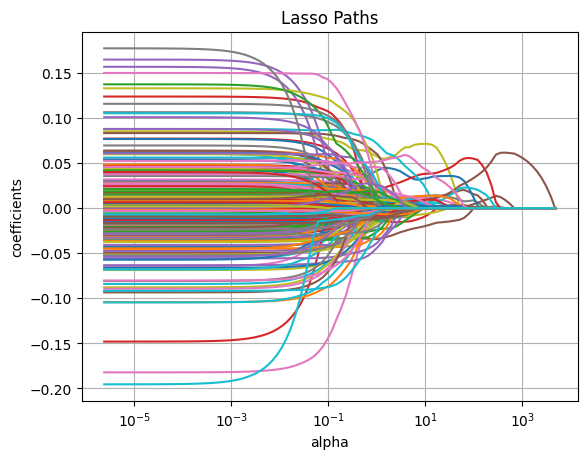

In [57]:
from sklearn.linear_model import lasso_path
from matplotlib import pyplot as plt

eps = 5e-10

print("Computing regularization path...")
alphas_lasso, coefs_lasso, _ = lasso_path(X_reduced, y, eps=eps)

for coef in coefs_lasso:
    l1 = plt.semilogx(alphas_lasso, coef)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.axis("tight")
plt.grid()